In [89]:
import tensorflow as tf
from models import decoder, encoder, vae
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from scipy.stats import norm
from hyperparameters import *
from sklearn.model_selection import train_test_split
import cv2

In [102]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "../data4",
    # validation_split=0.2,
    # subset="training",
    seed=123,
    batch_size=16,
    image_size=(64 + 64, 32 + 48),
)

Found 10463 files belonging to 1 classes.


In [103]:
img_processor = tf.keras.layers.CenterCrop(64, 32)

In [104]:
data = []
for images, labels in train_dataset.unbatch():
    data.append(images)
data = np.array(data) / 255

2024-05-24 14:45:14.877205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [105]:
x_train_org, x_val_org = train_test_split(data, test_size=0.2, random_state=42)
x_train, x_val = img_processor(x_train_org).numpy(), img_processor(x_val_org).numpy()

In [108]:
for i in range(len(x_train)):
    x_train[i] = cv2.blur(x_train[i], (10, 10), cv2.BORDER_DEFAULT)  

for i in range(len(x_val)):
    x_val[i] = cv2.blur(x_val[i], (10, 10), cv2.BORDER_DEFAULT)  

In [109]:
encoder_model = encoder.build_encoder(**ENCODER_MODEL_HYPERPARAMETERS)
decoder_model = decoder.build_decoder(**DECODER_MODEL_HYPERPARAMETERS)

vae_model = vae.VAE(encoder_model, decoder_model, reconstruction_loss_weight=100, kl_loss_weight=0.02)
vae_model.compile(optimizer="adam")

In [110]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_reconstruction_loss", patience=5, restore_best_weights=True, mode="min"
)

In [111]:
history_vae_training = vae_model.fit(x_train, epochs=500, batch_size=256, validation_data=x_val, callbacks=[early_stopping])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - kl_loss: 6698.4922 - loss: 124914.8047 - reconstruction_loss: 1247.8083 - val_kl_loss: 10033.4443 - val_loss: 110830.8828 - val_reconstruction_loss: 1106.3021
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - kl_loss: 8226.6416 - loss: 111612.1016 - reconstruction_loss: 1114.4757 - val_kl_loss: 8942.0000 - val_loss: 107669.1875 - val_reconstruction_loss: 1074.9034
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - kl_loss: 4870.8579 - loss: 109774.4062 - reconstruction_loss: 1096.7699 - val_kl_loss: 4103.6235 - val_loss: 106331.3750 - val_reconstruction_loss: 1062.4930
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - kl_loss: 3048.8398 - loss: 108639.3281 - reconstruction_loss: 1085.7834 - val_kl_loss: 2669.0239 - val_loss: 105758.8281 - val_reconstruction_loss: 1057.0544
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - kl_loss: 1244.5557 - loss: 107987.3672 - reconstruction_loss: 1079.6248 - val_kl_loss: 352.8588 

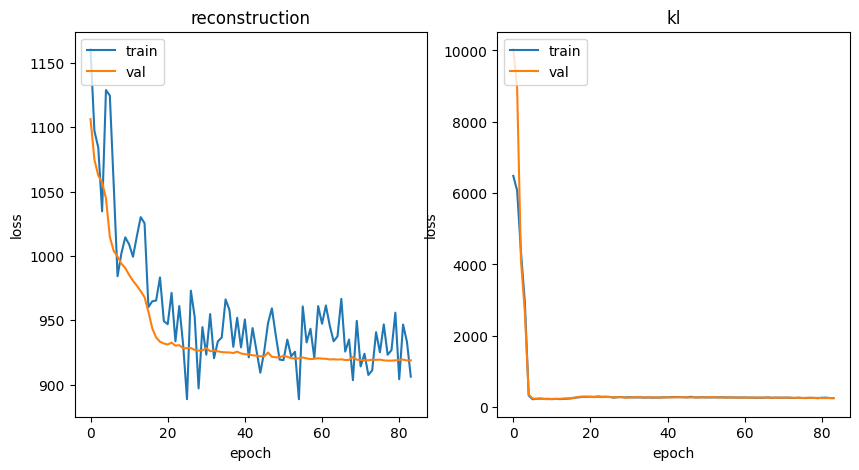

In [112]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history_vae_training.history["reconstruction_loss"])
plt.plot(history_vae_training.history["val_reconstruction_loss"])
plt.title("reconstruction")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")

plt.subplot(122)
plt.plot(history_vae_training.history["kl_loss"])
plt.plot(history_vae_training.history["val_kl_loss"])
plt.title("kl")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")

plt.show()

In [113]:
from scipy.cluster.hierarchy import dendrogram
from sklearn import cluster

def plot_dendrogram(mm, **kwargs):
    counts = np.zeros(mm.children_.shape[0])
    n_samples = len(mm.labels_)
    for i, merge in enumerate(mm.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [mm.children_, mm.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [167]:
ac = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# ac = cluster.AgglomerativeClustering(n_clusters=4)

_, _, z = encoder_model.predict(x_val)

classes = ac.fit_predict(z)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


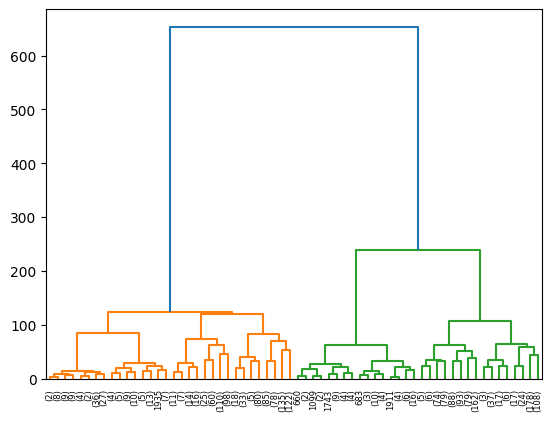

In [168]:
plot_dendrogram(ac, truncate_mode="level", p=5)

In [169]:
z.shape

(2093, 32)

Text(0, 0.5, 'Feature 15')

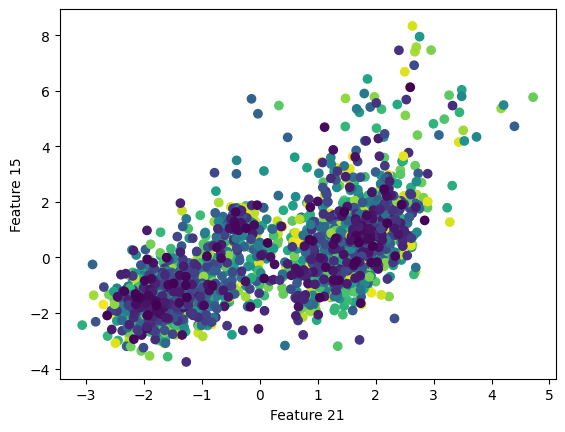

In [178]:
plt.scatter(z[:, 21], z[:, 15], c=classes)
plt.xlabel("Feature 21")
plt.ylabel("Feature 15")

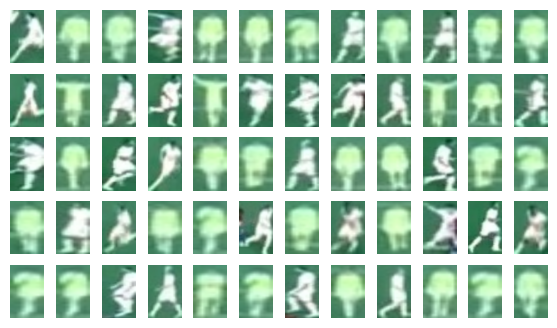

In [141]:
j = 0

plt.figure(figsize=(7, 4))
for i in range(len(classes)):
    if classes[i] == 3:
        plt.subplot(5, 12, j + 1)
        plt.imshow(x_val_org[i])
        plt.axis("off")
        j += 1
    if j == 60:
        break

plt.show()

ValueError: num must be an integer with 1 <= num <= 25, not 26

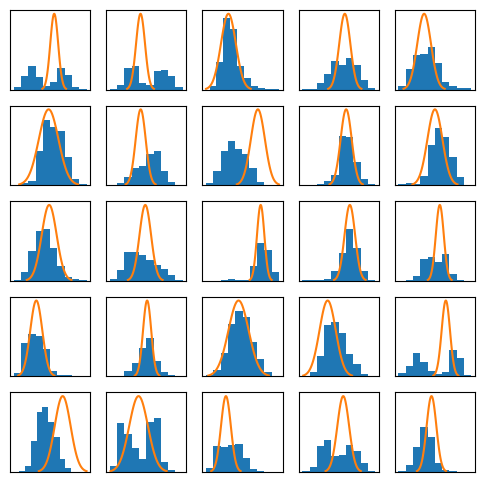

In [172]:
plot_size = int(np.sqrt(LATENT_DIM))

x_vector = np.linspace(-3, 3, 100)
norm_distribution = norm.pdf(x_vector, 0, 1)

plt.figure(figsize=(6, 6))
for i in range(LATENT_DIM):
    plt.subplot(plot_size, plot_size, i + 1)
    plt.hist(z[:, i], density=True)
    plt.plot(x_vector, norm_distribution)
    plt.xticks([])
    plt.yticks([])
plt.show()